# 单发多框检测（SSD）

## 模型

图 9.4 描述了 SSD 模型的设计。它主要由一个基础网络块和若干个多尺度特征块串联而成。其中基础网络块可以是一个卷积神经网络，例如在分类层之前截断的 VGG-16。我们可以设计基础网络，使它输出的高和宽较大。这样一来，基于该特征图生成的锚框数量较多，可以用来检测尺寸较小的目标。接下来的每个多尺度特征块将上一层提供的特征图的高和宽缩小（例如减半），并使特征图中每个单元在输入图像上的感受野变得更广阔。如此一来，图 9.4 中越靠近顶部的多尺度特征块输出的特征图越小，基于特征图生成的锚框故而也越少，加之特征图中每个单元感受野越大，因此更适合检测尺寸较大的目标。由于 SSD 基于基础网络块和各个多尺度特征块生成不同数量和不同大小的锚框，并通过预测锚框的类别和偏移量（即预测边界框）检测不同大小的目标，因此 SSD 是一个多尺度的目标检测模型。

![SSD模型主要由一个基础网络块和若干多尺度特征块串联而成。](../img/ssd.svg)


接下来我们介绍如何实现图中的各个模块。我们先介绍如何实现类别预测和边界框预测。

### 类别预测

设目标的类别个数为 $q$。每个锚框的类别个数将是 $q+1$，其中类别 0 表示锚框只包含背景。在某个尺度下，设特征图的高和宽分别为 $h$ 和 $w$，如果以其中每个单元为中心生成 $a$ 个锚框，那么我们将要对 $hwa$ 个锚框进行分类。



如果使用全连接层作为输出，可能会导致有过多的模型参数。回忆[“网络中的网络：NiN”](../chapter_convolutional-neural-networks/nin.md)这一节里我们介绍了使用卷积层的通道来输出类别预测，SSD 采用同样的方法来降低模型复杂度。

具体来说，类别预测层使用一个保持输入高宽的卷积层，其输出的 $(x,y)$ 像素通道里包含了以输入 $(x,y)$ 像素为中心的所有锚框的类别预测。其输出通道数为 $a(n+1)$，其中通道 $i(n+1)$ 是第 $i$ 个锚框预测的背景置信度，而通道 $i(n+1)+j+1$ 则是第 $i$ 锚框预测的第 $j$ 类目标的置信度。

下面我们定义一个这样的类别分类器，指定 $a$ 和 $n$ 后，它使用一个填充为 1 的 $3\times3$ 卷积层。注意到我们使用了较小的卷积窗口，它可能不能覆盖锚框定义的区域。所以我们需要保证前面的卷积层能有效的将较大的锚框区域的特征浓缩到一个 $3\times3$ 的窗口里。

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import gluonbook as gb
import mxnet as mx

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from mxnet import contrib,util as gutil,nd,autograd,init,image,gluon
from mxnet.gluon import loss as gloss,nn
import time

In [4]:
def cls_predictor(num_anchors,num_classes):
    return nn.Conv2D(num_anchors*(num_classes+1),kernel_size=3,padding=1)

## 边界预测框

* 这里和类别预测层的设计类似，唯一不同的是，这里需要为每个锚框预测4个偏移量

In [5]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors*4,kernel_size=3,padding=1)

### 合并多层的预测输出

SSD 中会在多个尺度上进行预测。由于每个尺度上的输入高宽和锚框的选取不一样，导致其形状各不相同。下面例子中我们构造两个尺度的输入，其中第二个为第一个的高宽减半。然后构造两个类别预测层，其分别对每个输入像素构造 5 个和 3 个锚框。

In [6]:
def forward(x,block):
    block.initialize()
    return block(x)
Y1 = forward(nd.zeros((2,8,20,20)),cls_predictor(5,10))
Y2 = forward(nd.zeros((2,16,10,10)),cls_predictor(3,10))
(Y1.shape,Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

预测的输出格式为（批量大小，通道数，高，宽）。可以看到除了批量大小外，其他维度大小均不一样。我们需要将它们变形成统一的格式并将多尺度的输出合并起来，让后续的处理变得简单。

我们首先将通道，即预测结果，放到最后。因为不同尺度下批量大小保持不变，所以将结果转成二维的（批量大小，高 $\times$ 宽 $\times$ 通道数）格式，方便之后的拼接。

In [7]:
def flatten_pred(pred):
    return pred.transpose((0,2,3,1)).flatten()

def concat_preds(preds):
    return nd.concat(*[flatten_pred(pred) for pred in preds],dim=1)


In [8]:
concat_preds([Y1, Y2]).shape

(2, 25300)

### 高和宽减半模块

减半模块将输入高宽减半来得到不同尺度的特征，这是通过步幅 2 的 $2\times2$ 最大池化层来完成。我们前面提到因为预测层的窗口为 3，所以我们需要额外卷积层来扩大其作用窗口来有效覆盖锚框区域。为此我们加入两个 $3\times3$ 卷积层，每个卷积层后接批量归一化层和 ReLU 激活层。这样，一个尺度上的 $3\times3$ 窗口覆盖了上一个尺度上的 $10\times10$ 窗口。

In [9]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels,kernel_size=3,padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu')
                )
    blk.add(nn.MaxPool2D(pool_size=2,strides=2))
    return blk

可见高和宽减半块的前向计算，改变了输入的通道数，并且将宽和高减半

In [10]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

### 基础网络块

主体网络用来从原始图像抽取特征，一般会选择常用的深度卷积神经网络。例如[1]中使用了 VGG，大家也常用 ResNet 替代。本小节为了计算简单，我们构造一个小的主体网络。网络中叠加三个减半模块，输出通道数从 16 开始，之后每个模块对其翻倍。

In [11]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16,32,64]:
        blk.add(down_sample_blk(num_filters)
        )
    return blk

In [12]:
forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

### 完整的模型

我们已经介绍了 SSD 模型中的各个功能模块，现在我们将构建整个模型。这个模型有五个模块，每个模块对输入进行特征抽取，并且预测锚框的类和偏移。第一个模块使用主体网络，第二到四模块使用减半模块，最后一个模块则使用全局的最大池化层来将高宽降到 1。下面函数定义如何构建这些模块。

In [13]:
def get_blk(i):
    if i==0:
        blk = base_net()
    elif i==4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

接下来我们定义每个模块如何进行前向计算。它跟之前的卷积神经网络不同在于，我们不仅输出卷积块的输出，而且还返回在输出上生成的锚框，以及每个锚框的类别预测和偏移预测。

In [14]:
def blk_forward(X,blk,sizes,ratios,cls_predictor,bbox_predictor):
    #首先使用网络抽取特征
    Y = blk(X)
    #print(Y)
    anchors = contrib.ndarray.MultiBoxPrior(Y,sizes=sizes,ratios=ratios) #在特征图上生成锚框
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    
    return (Y, anchors, cls_preds, bbox_preds)
    

对每个模块我们要定义其输出上的锚框如何生成。比例固定成 1、2 和 0.5，但大小上则不同，用于覆盖不同的尺度。

In [15]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
        [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

## 下面我们可以完整定义我们的SSD模型

In [16]:
class TinySSD(nn.Block):
    def __init__(self,num_classes,**kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes = num_classes
        
        for i in range(5):
            # 即赋值语句 self.blk_i = get_blk(i)
            setattr(self,'blk_%d' % i,get_blk(i))
            setattr(self,'cls_%d' % i,cls_predictor(num_anchors,
                                                    num_classes))
            setattr(self,'bbox_%d' % i ,bbox_predictor(num_anchors))
    def forward(self,X):
        #首先采用basenet提取特征
        anchors,cls_preds,bbox_pred = [None]*5,[None]*5,[None]*5
        for i in range(5):
            X,anchors[i],cls_preds[i],bbox_pred[i] = blk_forward(X,getattr(self,'blk_%d' % i),sizes[i],ratios[i],
                                                               getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
           # reshape 函数中的 0 表⽰保持批量⼤⼩不变
           # 生成的每个锚框为 (batch_size,wh(n+m-1),4)
        return (nd.concat(*anchors,dim=1),concat_preds(cls_preds).reshape((0,-1,(self.num_classes+1))),concat_preds(bbox_pred))
                
        

In [17]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32,3,256,256))
anchors,cls_preds,bbox_preds = net(X)

In [18]:
print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


## 训练

* 读取数据和初始化

In [19]:
batch_size = 8
train_data,test_data=gb.load_data_pikachu(batch_size)
# 为保证 GPU 计算效率，这⾥为每张训练图像填充了两个标签为 -1 的边界框。
train_data.reshape(label_shape=(3, 5))

In [20]:
train_data.next().data

[
 [[[[-1.0733795  -0.45688844 -0.2856409  ... -0.55963695 -0.52538747
     -0.55963695]
    [-1.2103776  -0.59388644 -0.3883894  ... -0.49113795 -0.47401318
     -0.49113795]
    [-1.4672489  -0.9877558  -0.765134   ... -0.45688844 -0.47401318
     -0.5082627 ]
    ...
    [-0.42263892 -0.45688844 -0.59388644 ... -0.8507578  -0.81650823
     -1.1076291 ]
    [-0.45688844 -0.42263892 -0.33701515 ... -0.66238546 -0.5082627
     -0.45688844]
    [-0.49113795 -0.3883894  -0.52538747 ... -0.11439336 -0.08014385
     -0.16576762]]
 
   [[-0.582633    0.01260506  0.2051821  ... -0.09243695 -0.05742295
     -0.03991595]
    [-0.60014004 -0.02240894  0.11764708 ... -0.02240894  0.01260506
      0.03011207]
    [-0.74019605 -0.302521   -0.16246496 ...  0.01260506  0.01260506
      0.03011207]
    ...
    [-0.61764705 -0.652661   -0.7927171  ... -0.7752101  -0.652661
     -0.8627451 ]
    [-0.652661   -0.61764705 -0.530112   ... -0.75770307 -0.60014004
     -0.54761904]
    [-0.68767506 -0.58263

In [21]:
ctx,net = gb.try_gpu(),TinySSD(num_classes=1)
net.initialize(init=init.Xavier(),ctx=ctx)
trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':0.2,'wd':5e-4})


### 损失和评估函数

目标检测有两个损失函数，一是对每个锚框的类别预测，我们可以重用之前图像分类问题里一直使用的 Softmax 和交叉熵损失。二是正类锚框的偏移预测。它是一个回归问题，但我们这里不使用前面介绍过的 L2 损失函数，而是使用惩罚相对更小的线性 L1 损失函数，即 $l_1(\hat y, y) = |\hat y - y|$。

In [22]:
cls_loss = gloss.SoftmaxCrossEntropyLoss()
bbox_loss = gloss.L1Loss()


In [23]:
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

对于分类好坏我们可以沿用之前的分类精度。因为使用了 L1 损失，我们用平均绝对误差评估边框预测的性能。

In [24]:
def cls_metric(cls_preds, cls_labels):
    # 注意这里类别预测结果放在最后一维，argmax 的时候指定使用最后一维。
    return (cls_preds.argmax(axis=-1) == cls_labels).mean().asscalar()

def bbox_metric(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().mean().asscalar()

## 预测和回归均是在anchorbox上做

In [25]:
for epoch in range(5):
    acc, mae = 0, 0
    train_data.reset()  # 从头读取数据。
    start = time.time()
    cnt = 0 
    for i, batch in enumerate(train_data):
        # 复制数据到 GPU。
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 对每个锚框预测输出。
            anchors, cls_preds, bbox_preds = net(X)
            # 对每个锚框生成标号。
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 计算类别预测和边界框预测损失。
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        # 计算梯度和更新模型。
        l.backward()
        trainer.step(batch_size)
        # 更新类别预测和边界框预测评估。
        cnt+=1
        acc += cls_metric(cls_preds, cls_labels)
        mae += bbox_metric(bbox_preds, bbox_labels, bbox_masks)
        
        if (cnt) % 10 == 0:
            print('cnt %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
               cnt, 1 - acc / (10), mae / (10), time.time() - start))
            acc, mae = 0, 0
            start = time.time()

cnt 10, class err 6.07e-02, bbox mae 1.19e-02, time 3.5 sec
cnt 20, class err 2.24e-03, bbox mae 9.78e-04, time 1.7 sec
cnt 30, class err 2.10e-03, bbox mae 6.33e-04, time 1.6 sec
cnt 40, class err 1.45e-03, bbox mae 5.62e-04, time 1.7 sec
cnt 50, class err 4.62e-04, bbox mae 4.77e-04, time 1.7 sec
cnt 60, class err 4.59e-04, bbox mae 5.70e-04, time 1.8 sec
cnt 70, class err 4.02e-04, bbox mae 5.13e-04, time 1.6 sec
cnt 80, class err 3.97e-04, bbox mae 5.16e-04, time 1.7 sec
cnt 90, class err 4.48e-04, bbox mae 5.55e-04, time 1.6 sec
cnt 100, class err 4.43e-04, bbox mae 5.41e-04, time 1.6 sec
cnt 110, class err 4.43e-04, bbox mae 4.84e-04, time 1.7 sec
cnt 120, class err 3.44e-04, bbox mae 4.22e-04, time 1.6 sec
cnt 130, class err 2.94e-04, bbox mae 3.80e-04, time 1.7 sec
cnt 140, class err 4.00e-04, bbox mae 4.46e-04, time 1.7 sec
cnt 150, class err 3.47e-04, bbox mae 4.08e-04, time 1.7 sec
cnt 160, class err 3.77e-04, bbox mae 4.30e-04, time 1.7 sec
cnt 170, class err 4.52e-04, bbox

cnt 1350, class err 4.89e-04, bbox mae 7.69e-04, time 1.7 sec
cnt 1360, class err 3.28e-04, bbox mae 4.15e-04, time 1.6 sec
cnt 1370, class err 2.96e-04, bbox mae 3.29e-04, time 1.7 sec
cnt 1380, class err 3.86e-04, bbox mae 4.02e-04, time 1.7 sec
cnt 1390, class err 3.74e-04, bbox mae 4.07e-04, time 1.7 sec
cnt 1400, class err 4.00e-04, bbox mae 4.18e-04, time 1.7 sec
cnt 1410, class err 3.72e-04, bbox mae 3.66e-04, time 1.7 sec
cnt 1420, class err 4.25e-04, bbox mae 3.92e-04, time 1.7 sec
cnt 1430, class err 4.06e-04, bbox mae 3.89e-04, time 1.7 sec
cnt 1440, class err 4.18e-04, bbox mae 4.20e-04, time 1.7 sec
cnt 1450, class err 3.90e-04, bbox mae 3.88e-04, time 1.7 sec
cnt 1460, class err 5.33e-04, bbox mae 5.32e-04, time 1.7 sec
cnt 1470, class err 3.56e-04, bbox mae 5.38e-04, time 1.6 sec
cnt 1480, class err 3.67e-04, bbox mae 8.87e-04, time 1.7 sec
cnt 1490, class err 3.67e-04, bbox mae 5.38e-04, time 1.7 sec
cnt 1500, class err 3.31e-04, bbox mae 3.95e-04, time 1.6 sec
cnt 1510

cnt 2680, class err 3.83e-04, bbox mae 5.77e-04, time 1.6 sec
cnt 2690, class err 4.41e-04, bbox mae 6.93e-04, time 1.6 sec
cnt 2700, class err 4.73e-04, bbox mae 6.77e-04, time 1.6 sec
cnt 2710, class err 4.13e-04, bbox mae 5.78e-04, time 1.6 sec
cnt 2720, class err 3.44e-04, bbox mae 4.46e-04, time 1.6 sec
cnt 2730, class err 1.50e-03, bbox mae 3.60e-04, time 1.6 sec
cnt 2740, class err 4.64e-04, bbox mae 4.98e-04, time 1.6 sec
cnt 2750, class err 1.12e-03, bbox mae 4.52e-04, time 1.6 sec
cnt 2760, class err 9.78e-04, bbox mae 7.02e-04, time 1.6 sec
cnt 2770, class err 2.28e-03, bbox mae 1.08e-03, time 1.6 sec
cnt 2780, class err 1.12e-03, bbox mae 7.99e-04, time 1.6 sec
cnt 2790, class err 3.13e-03, bbox mae 7.67e-04, time 1.6 sec
cnt 2800, class err 5.26e-04, bbox mae 1.49e-03, time 1.6 sec
cnt 2810, class err 5.92e-04, bbox mae 8.61e-04, time 1.6 sec
cnt 2820, class err 9.18e-04, bbox mae 7.07e-04, time 1.7 sec
cnt 2830, class err 3.49e-04, bbox mae 4.62e-04, time 1.7 sec
cnt 2840

cnt 4010, class err 6.34e-04, bbox mae 1.43e-02, time 1.7 sec
cnt 4020, class err 7.83e-04, bbox mae 4.25e-03, time 1.6 sec
cnt 4030, class err 5.01e-04, bbox mae 1.44e-02, time 1.7 sec
cnt 4040, class err 5.88e-04, bbox mae 1.96e-02, time 1.7 sec
cnt 4050, class err 6.45e-04, bbox mae 1.59e-02, time 1.7 sec
cnt 4060, class err 7.19e-04, bbox mae 1.59e-02, time 1.7 sec
cnt 4070, class err 4.18e-04, bbox mae 5.37e-03, time 1.7 sec
cnt 4080, class err 5.53e-04, bbox mae 4.51e-03, time 1.7 sec
cnt 4090, class err 7.44e-04, bbox mae 3.51e-03, time 1.7 sec
cnt 4100, class err 4.45e-04, bbox mae 3.51e-03, time 1.7 sec
cnt 4110, class err 9.37e-04, bbox mae 3.25e-03, time 1.6 sec
cnt 4120, class err 8.91e-04, bbox mae 7.75e-03, time 1.7 sec
cnt 4130, class err 8.24e-04, bbox mae 9.80e-03, time 1.7 sec
cnt 4140, class err 5.69e-04, bbox mae 4.85e-03, time 1.7 sec
cnt 4150, class err 8.77e-04, bbox mae 1.63e-03, time 1.7 sec
cnt 4160, class err 7.94e-04, bbox mae 1.60e-02, time 1.7 sec
cnt 4170

cnt 5340, class err 3.67e-04, bbox mae 4.36e-04, time 1.6 sec
cnt 5350, class err 3.77e-04, bbox mae 3.96e-04, time 1.7 sec
cnt 5360, class err 3.88e-04, bbox mae 3.33e-04, time 1.7 sec
cnt 5370, class err 4.13e-04, bbox mae 4.06e-04, time 1.7 sec
cnt 5380, class err 4.78e-04, bbox mae 8.11e-04, time 1.7 sec
cnt 5390, class err 3.77e-04, bbox mae 1.93e-03, time 1.7 sec
cnt 5400, class err 4.48e-04, bbox mae 6.23e-04, time 1.6 sec
cnt 5410, class err 4.57e-04, bbox mae 5.59e-04, time 1.7 sec
cnt 5420, class err 4.64e-04, bbox mae 4.31e-04, time 1.7 sec
cnt 5430, class err 3.21e-04, bbox mae 4.11e-04, time 1.6 sec
cnt 5440, class err 2.98e-04, bbox mae 3.12e-04, time 1.7 sec
cnt 5450, class err 4.00e-04, bbox mae 3.50e-04, time 1.6 sec
cnt 5460, class err 3.56e-04, bbox mae 5.01e-04, time 1.7 sec
cnt 5470, class err 3.79e-04, bbox mae 3.38e-04, time 1.6 sec
cnt 5480, class err 4.45e-04, bbox mae 3.97e-04, time 1.7 sec
cnt 5490, class err 3.97e-04, bbox mae 5.11e-04, time 1.7 sec
cnt 5500

cnt 6670, class err 3.03e-04, bbox mae 1.35e-02, time 1.6 sec
cnt 6680, class err 3.38e-04, bbox mae 1.17e-02, time 1.6 sec
cnt 6690, class err 4.00e-04, bbox mae 1.02e-02, time 1.7 sec
cnt 6700, class err 3.54e-04, bbox mae 1.38e-02, time 1.7 sec
cnt 6710, class err 4.20e-04, bbox mae 1.83e-02, time 1.7 sec
cnt 6720, class err 3.40e-04, bbox mae 2.25e-02, time 1.7 sec
cnt 6730, class err 1.21e-02, bbox mae 5.01e-02, time 1.7 sec
cnt 6740, class err 4.29e-04, bbox mae 5.44e-02, time 1.7 sec
cnt 6750, class err 4.16e-04, bbox mae 3.47e-02, time 1.7 sec
cnt 6760, class err 3.83e-04, bbox mae 2.53e-02, time 1.7 sec
cnt 6770, class err 5.12e-04, bbox mae 2.26e-02, time 1.6 sec
cnt 6780, class err 3.79e-04, bbox mae 1.81e-02, time 1.6 sec
cnt 6790, class err 3.60e-04, bbox mae 1.44e-02, time 1.7 sec
cnt 6800, class err 3.42e-04, bbox mae 1.03e-02, time 1.7 sec
cnt 6810, class err 3.49e-04, bbox mae 1.68e-02, time 1.6 sec
cnt 6820, class err 4.06e-04, bbox mae 1.60e-02, time 1.7 sec
cnt 6830

cnt 8000, class err 6.80e-04, bbox mae 4.44e-02, time 1.7 sec
cnt 8010, class err 5.86e-04, bbox mae 4.17e-02, time 1.6 sec
cnt 8020, class err 5.63e-04, bbox mae 3.37e-02, time 1.7 sec
cnt 8030, class err 4.66e-04, bbox mae 2.29e-02, time 1.6 sec
cnt 8040, class err 3.01e-04, bbox mae 1.52e-02, time 1.7 sec
cnt 8050, class err 6.15e-04, bbox mae 2.48e-02, time 1.7 sec
cnt 8060, class err 4.25e-04, bbox mae 2.50e-02, time 1.7 sec
cnt 8070, class err 5.83e-04, bbox mae 2.09e-02, time 1.6 sec
cnt 8080, class err 4.66e-04, bbox mae 2.13e-02, time 1.7 sec
cnt 8090, class err 7.26e-04, bbox mae 3.37e-02, time 1.7 sec
cnt 8100, class err 3.93e-04, bbox mae 1.68e-02, time 1.7 sec
cnt 8110, class err 5.83e-04, bbox mae 3.21e-02, time 1.6 sec
cnt 8120, class err 7.19e-04, bbox mae 4.22e-02, time 1.7 sec
cnt 8130, class err 6.20e-04, bbox mae 4.49e-02, time 1.7 sec
cnt 8140, class err 4.73e-04, bbox mae 2.02e-02, time 1.6 sec
cnt 8150, class err 3.51e-04, bbox mae 1.17e-02, time 1.7 sec
cnt 8160

cnt 9330, class err 8.91e-04, bbox mae 7.03e-03, time 1.7 sec
cnt 9340, class err 4.06e-04, bbox mae 3.60e-03, time 1.6 sec
cnt 9350, class err 4.18e-04, bbox mae 5.86e-03, time 1.7 sec
cnt 9360, class err 3.90e-04, bbox mae 8.17e-03, time 1.7 sec
cnt 9370, class err 2.68e-03, bbox mae 8.44e-03, time 1.7 sec
cnt 9380, class err 3.38e-04, bbox mae 3.62e-03, time 1.6 sec
cnt 9390, class err 3.67e-04, bbox mae 2.21e-03, time 1.6 sec
cnt 9400, class err 3.67e-04, bbox mae 1.65e-03, time 1.7 sec
cnt 9410, class err 3.31e-04, bbox mae 1.73e-03, time 1.6 sec
cnt 9420, class err 4.27e-04, bbox mae 2.64e-03, time 1.7 sec
cnt 9430, class err 5.07e-04, bbox mae 2.74e-03, time 1.6 sec
cnt 9440, class err 1.63e-03, bbox mae 9.05e-03, time 1.7 sec
cnt 9450, class err 4.16e-04, bbox mae 5.48e-03, time 1.7 sec
cnt 9460, class err 3.83e-04, bbox mae 3.40e-03, time 1.6 sec
cnt 9470, class err 4.41e-04, bbox mae 4.38e-03, time 1.6 sec
cnt 9480, class err 2.41e-03, bbox mae 5.21e-03, time 1.7 sec
cnt 9490

cnt 10650, class err 4.75e-04, bbox mae 1.74e-03, time 1.7 sec
cnt 10660, class err 1.04e-03, bbox mae 7.00e-04, time 1.7 sec
cnt 10670, class err 3.81e-04, bbox mae 7.78e-04, time 1.6 sec
cnt 10680, class err 5.58e-04, bbox mae 1.06e-03, time 1.7 sec
cnt 10690, class err 4.50e-04, bbox mae 1.13e-03, time 1.7 sec
cnt 10700, class err 3.42e-04, bbox mae 1.09e-03, time 1.7 sec
cnt 10710, class err 5.10e-04, bbox mae 2.10e-03, time 1.6 sec
cnt 10720, class err 4.04e-04, bbox mae 1.79e-03, time 1.7 sec
cnt 10730, class err 4.68e-04, bbox mae 1.26e-03, time 1.7 sec
cnt 10740, class err 3.49e-04, bbox mae 9.42e-04, time 1.6 sec
cnt 10750, class err 2.89e-04, bbox mae 5.53e-04, time 1.7 sec
cnt 10760, class err 4.13e-04, bbox mae 6.63e-04, time 1.6 sec
cnt 10770, class err 3.56e-04, bbox mae 6.28e-04, time 1.6 sec
cnt 10780, class err 3.83e-04, bbox mae 7.61e-04, time 1.7 sec
cnt 10790, class err 4.36e-04, bbox mae 1.19e-03, time 1.7 sec
cnt 10800, class err 3.90e-04, bbox mae 1.82e-03, time 

cnt 11960, class err 3.48e-03, bbox mae 6.49e-04, time 1.6 sec
cnt 11970, class err 5.58e-04, bbox mae 8.18e-04, time 1.7 sec
cnt 11980, class err 3.21e-04, bbox mae 5.54e-04, time 1.6 sec
cnt 11990, class err 1.77e-03, bbox mae 5.23e-04, time 1.7 sec
cnt 12000, class err 4.00e-04, bbox mae 7.04e-04, time 1.7 sec
cnt 12010, class err 1.45e-03, bbox mae 8.57e-04, time 1.7 sec
cnt 12020, class err 4.34e-04, bbox mae 7.65e-04, time 1.7 sec
cnt 12030, class err 5.40e-04, bbox mae 6.24e-04, time 1.6 sec
cnt 12040, class err 1.94e-03, bbox mae 1.65e-03, time 1.7 sec
cnt 12050, class err 4.02e-04, bbox mae 7.13e-04, time 1.7 sec
cnt 12060, class err 4.34e-04, bbox mae 1.39e-03, time 1.7 sec
cnt 12070, class err 8.17e-04, bbox mae 1.45e-03, time 1.7 sec
cnt 12080, class err 2.24e-03, bbox mae 1.27e-03, time 1.7 sec
cnt 12090, class err 3.77e-04, bbox mae 4.90e-04, time 1.7 sec
cnt 12100, class err 6.80e-04, bbox mae 3.94e-04, time 1.6 sec
cnt 12110, class err 3.24e-04, bbox mae 4.07e-04, time 

cnt 13270, class err 4.50e-04, bbox mae 3.66e-04, time 1.7 sec
cnt 13280, class err 1.31e-03, bbox mae 4.25e-04, time 1.7 sec
cnt 13290, class err 5.88e-04, bbox mae 3.88e-04, time 1.7 sec
cnt 13300, class err 4.96e-04, bbox mae 3.46e-04, time 1.7 sec
cnt 13310, class err 1.55e-03, bbox mae 4.17e-04, time 1.7 sec
cnt 13320, class err 4.64e-04, bbox mae 4.19e-04, time 1.7 sec
cnt 13330, class err 4.43e-04, bbox mae 4.09e-04, time 1.7 sec
cnt 13340, class err 3.21e-04, bbox mae 3.04e-04, time 1.6 sec
cnt 13350, class err 3.05e-04, bbox mae 2.68e-04, time 1.7 sec
cnt 13360, class err 4.22e-04, bbox mae 3.98e-04, time 1.6 sec
cnt 13370, class err 3.60e-04, bbox mae 3.55e-04, time 1.6 sec
cnt 13380, class err 3.88e-04, bbox mae 5.31e-04, time 1.7 sec
cnt 13390, class err 9.87e-04, bbox mae 8.83e-04, time 1.7 sec
cnt 13400, class err 4.06e-03, bbox mae 3.74e-04, time 1.6 sec
cnt 13410, class err 7.94e-04, bbox mae 3.60e-04, time 1.7 sec
cnt 13420, class err 4.40e-03, bbox mae 1.15e-03, time 

cnt 14580, class err 3.03e-04, bbox mae 3.32e-04, time 1.6 sec
cnt 14590, class err 1.15e-03, bbox mae 3.49e-04, time 1.7 sec
cnt 14600, class err 4.00e-04, bbox mae 4.00e-04, time 1.7 sec
cnt 14610, class err 3.54e-04, bbox mae 3.49e-04, time 1.7 sec
cnt 14620, class err 4.20e-04, bbox mae 4.09e-04, time 1.7 sec
cnt 14630, class err 3.40e-04, bbox mae 3.23e-04, time 1.7 sec
cnt 14640, class err 4.22e-04, bbox mae 3.65e-04, time 1.7 sec
cnt 14650, class err 4.29e-04, bbox mae 3.86e-04, time 1.7 sec
cnt 14660, class err 4.16e-04, bbox mae 3.78e-04, time 1.7 sec
cnt 14670, class err 3.83e-04, bbox mae 3.55e-04, time 1.7 sec
cnt 14680, class err 5.12e-04, bbox mae 4.76e-04, time 1.7 sec
cnt 14690, class err 3.79e-04, bbox mae 3.65e-04, time 1.6 sec
cnt 14700, class err 3.60e-04, bbox mae 3.61e-04, time 1.7 sec
cnt 14710, class err 3.42e-04, bbox mae 3.27e-04, time 1.7 sec
cnt 14720, class err 3.49e-04, bbox mae 3.39e-04, time 1.7 sec
cnt 14730, class err 4.06e-04, bbox mae 3.82e-04, time 

cnt 15890, class err 6.45e-04, bbox mae 6.36e-04, time 1.7 sec
cnt 15900, class err 6.87e-04, bbox mae 5.06e-04, time 1.7 sec
cnt 15910, class err 2.43e-03, bbox mae 4.31e-04, time 1.6 sec
cnt 15920, class err 2.64e-03, bbox mae 4.22e-04, time 1.7 sec
cnt 15930, class err 4.50e-03, bbox mae 1.36e-03, time 1.8 sec
cnt 15940, class err 6.81e-03, bbox mae 1.44e-03, time 1.7 sec
cnt 15950, class err 5.04e-03, bbox mae 6.21e-04, time 2.0 sec
cnt 15960, class err 8.48e-03, bbox mae 2.88e-03, time 1.9 sec
cnt 15970, class err 2.25e-03, bbox mae 3.03e-03, time 1.8 sec
cnt 15980, class err 4.58e-03, bbox mae 5.67e-03, time 1.7 sec
cnt 15990, class err 1.23e-03, bbox mae 1.12e-02, time 1.7 sec
cnt 16000, class err 2.65e-03, bbox mae 5.26e-03, time 1.7 sec
cnt 16010, class err 1.87e-03, bbox mae 2.91e-03, time 1.7 sec
cnt 16020, class err 7.49e-04, bbox mae 1.89e-03, time 1.7 sec
cnt 16030, class err 3.48e-03, bbox mae 1.90e-03, time 1.7 sec
cnt 16040, class err 2.99e-03, bbox mae 4.99e-03, time 

cnt 17200, class err 3.86e-04, bbox mae 4.99e-04, time 1.7 sec
cnt 17210, class err 3.74e-04, bbox mae 5.40e-04, time 1.7 sec
cnt 17220, class err 4.00e-04, bbox mae 5.20e-04, time 1.7 sec
cnt 17230, class err 3.72e-04, bbox mae 4.91e-04, time 1.7 sec
cnt 17240, class err 4.25e-04, bbox mae 5.40e-04, time 1.7 sec
cnt 17250, class err 4.06e-04, bbox mae 6.18e-04, time 1.7 sec
cnt 17260, class err 4.18e-04, bbox mae 6.04e-04, time 1.7 sec
cnt 17270, class err 3.90e-04, bbox mae 5.63e-04, time 1.7 sec
cnt 17280, class err 5.33e-04, bbox mae 6.22e-04, time 1.7 sec
cnt 17290, class err 3.35e-04, bbox mae 4.12e-04, time 1.6 sec
cnt 17300, class err 3.67e-04, bbox mae 4.36e-04, time 2.0 sec
cnt 17310, class err 3.67e-04, bbox mae 4.52e-04, time 2.0 sec
cnt 17320, class err 3.31e-04, bbox mae 3.87e-04, time 1.8 sec
cnt 17330, class err 4.27e-04, bbox mae 4.91e-04, time 1.7 sec
cnt 17340, class err 3.26e-04, bbox mae 3.90e-04, time 1.8 sec
cnt 17350, class err 4.52e-04, bbox mae 4.96e-04, time 

KeyboardInterrupt: 

In [ ]:
train()

## 预测
在预测阶段，我们希望能把图像里面所有感兴趣的目标找出来。我们首先定义一个图像预处理函数，它对图像进行变换然后转成卷积层需要的四维格式。

In [29]:
img = image.imread('../img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)
X


[[[[178. 173. 170. ... 173. 151. 145.]
   [189. 180. 181. ... 159. 141. 144.]
   [204. 188. 199. ... 162. 151. 141.]
   ...
   [103. 105. 112. ... 113. 116. 121.]
   [101. 103. 106. ... 103. 119. 117.]
   [106. 107. 106. ... 118. 127. 129.]]

  [[179. 174. 172. ... 165. 147. 143.]
   [190. 181. 182. ... 151. 138. 142.]
   [203. 188. 200. ... 157. 148. 139.]
   ...
   [ 88.  90.  97. ...  92.  94.  98.]
   [ 86.  87.  90. ...  82.  98.  95.]
   [ 89.  90.  89. ...  99. 106. 108.]]

  [[201. 198. 197. ... 181. 165. 164.]
   [211. 202. 204. ... 167. 156. 163.]
   [220. 205. 219. ... 170. 167. 163.]
   ...
   [ 81.  83.  90. ...  74.  72.  75.]
   [ 79.  80.  83. ...  66.  78.  72.]
   [ 82.  83.  81. ...  83.  86.  84.]]]]
<NDArray 1x3x256x256 @cpu(0)>

在预测的时候，我们通过`MultiBoxDetection`函数来合并预测偏移和锚框得到预测边界框，并使用 NMS 去除重复的预测边界框。

In [30]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
    return output[0, idx]

output = predict(X)

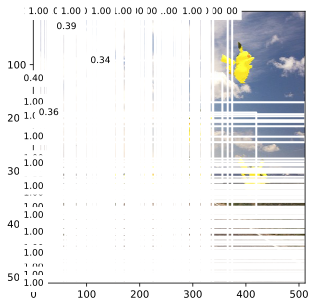

In [31]:
gb.set_figsize((5, 5))

def display(img, output, threshold):
    fig = gb.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        gb.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)